In [53]:
import pandas as pd
import os
import seaborn as sns
from config import *
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
result_dir='performance_prediction_results_different_iterations'

visualizations_dir='performance_prediction_visualizations_different_iterations'
seeds=[200,400,600,800,1000]
seed_mapping={index:seed for index,seed in enumerate(seeds)}

In [3]:
os.makedirs(visualizations_dir, exist_ok=True)

In [4]:
baseline_precision_at_iteration=pd.read_csv('algorithm_run_data/all_algorithms_precision_per_iteration.csv',index_col=[0],compression='zip')

In [5]:
baseline_precision_at_iteration=baseline_precision_at_iteration.drop(columns=['y','min_up_to_iteration']).rename(columns={ 'precision_at_iteration':'baseline_precision_at_iteration'})

In [6]:
baseline_precision_at_iteration=baseline_precision_at_iteration.set_index(['dimension','algorithm_name','problem_id','instance_id','seed','iteration'])

In [7]:
def get_global_file_name(dimension,algorithms, iteration_start,iteration_end,predict_iteration, predict_log_precision,seed, difference):
    return os.path.join(result_dir,f'dim_{dimension}_{algorithms}_it_{iteration_start}-{iteration_end}_predict_it_{predict_iteration}_instance_count_99_seed_{seed}_log_{predict_log_precision}{"_differenced" if difference else ""}')


In [8]:
def get_predictions_df(dimension,algorithm, iteration_start, iteration_end,predict_iteration, predict_log_precision,difference, seeds):
    test_df_all=pd.DataFrame()
    for train_seed in seeds:
        test_df=pd.DataFrame()
        for fold in range(0,10):

            global_file_name=get_global_file_name(dimension,algorithm, iteration_start,iteration_end,predict_iteration, predict_log_precision,train_seed, difference)
            file_location=global_file_name+f'_fold_{fold}_test_preds.csv'

            if not os.path.isfile(file_location):
                print('Not found', file_location)
                continue
            #print(file_location)
            test_df_fold=pd.read_csv(file_location, index_col=[0], compression='zip')
            
            test_df_fold['fold']=fold
            test_df_fold['seed']=train_seed
            test_df=pd.concat([test_df,test_df_fold])
            test_df_all=pd.concat([test_df_all,test_df_fold])
    if test_df_all.shape[0]==0:
        return test_df_all
    if predict_log_precision:
        test_df_all['preds']=test_df_all['preds'].apply(lambda x: np.exp(x))
        test_df_all['y']=test_df_all['y'].apply(lambda x: np.exp(x))
    return test_df_all
    

In [134]:
def get_errors_for_algorithm(dimension,algorithm,start_iteration,end_iteration,predict_iteration, predict_log_precision,difference,seeds):
    all_predictions = get_predictions_df(dimension,algorithm,0,end_iteration,predict_iteration, predict_log_precision=predict_log_precision,difference=difference,seeds=seeds)

    dr_mae=mean_absolute_error(all_predictions['y'], all_predictions['preds'])
    dr_mse=mean_squared_error(all_predictions['y'], all_predictions['preds'], squared=False)
    

    all_predictions['iteration']=end_iteration
    all_predictions['dimension']=dimension
    
    baseline_df=all_predictions.merge(baseline_precision_at_iteration, left_on=['dimension','algorithm_name','problem_id','instance_id','seed','iteration'],right_on=['dimension','algorithm_name','problem_id','instance_id','seed','iteration'])
    
    baseline_mae=mean_absolute_error(baseline_df['y'], baseline_df['baseline_precision_at_iteration'])
    baseline_mse=mean_squared_error(baseline_df['y'], baseline_df['baseline_precision_at_iteration'], squared=False)
    return algorithm, end_iteration+1, dr_mse, baseline_mse,predict_iteration

In [136]:
algorithm='ES'
dimension=3


errors_for_dimension=[]
for end_iteration in [0,2,19,29]:
    for predict_iteration in [19,29,39,49]:
        if end_iteration<predict_iteration:
            errors_per_algorithm= get_errors_for_algorithm(dimension,algorithm,0,end_iteration=end_iteration, predict_iteration=predict_iteration,predict_log_precision=False,difference=False,seeds=seeds)
            print(errors_per_algorithm)
            errors_for_dimension+=[errors_per_algorithm]

errors_for_dimension_df=pd.DataFrame(errors_for_dimension, columns=['algorithm', 'feature calculation budget (iterations)', 'DynamoRep MSE', 'Baseline MSE','predict iteration'])
errors_for_dimension_df=errors_for_dimension_df.melt(id_vars=['algorithm','feature calculation budget (iterations)','predict iteration'], value_vars=['DynamoRep MSE', 'Baseline MSE'], value_name='performance')
errors_for_dimension_df

('ES', 1, 12552.014032928273, 402015.92000940454, 19)
('ES', 1, 12566.067422092416, 402015.92000940454, 29)
('ES', 1, 12558.172562966864, 402015.92000940454, 39)
('ES', 1, 12550.796719145306, 402015.92000940454, 49)
('ES', 3, 2398.8813694245637, 11276.717270360323, 19)
('ES', 3, 2398.5288869963324, 11276.717270360323, 29)
('ES', 3, 2401.8639889629494, 11276.717270360323, 39)
('ES', 3, 2402.4132828253296, 11276.717270360323, 49)
('ES', 20, 1.4761106828905326, 12.311008353347903, 29)
('ES', 20, 1.4609240868030537, 12.311008353347903, 39)
('ES', 20, 1.473035854970324, 12.311008353347903, 49)
('ES', 30, 1.17540563933297, 1.0186973931753989, 39)
('ES', 30, 1.1917368651291151, 1.0186973931753989, 49)


,algorithm,feature calculation budget (iterations),predict iteration,variable,performance
0,ES,1,19,DynamoRep MSE,12552.014033
1,ES,1,29,DynamoRep MSE,12566.067422
2,ES,1,39,DynamoRep MSE,12558.172563
3,ES,1,49,DynamoRep MSE,12550.796719
4,ES,3,19,DynamoRep MSE,2398.881369
5,ES,3,29,DynamoRep MSE,2398.528887
6,ES,3,39,DynamoRep MSE,2401.863989
7,ES,3,49,DynamoRep MSE,2402.413283
8,ES,20,29,DynamoRep MSE,1.476111
9,ES,20,39,DynamoRep MSE,1.460924


In [141]:
errors_for_dimension_df['log_performance']=errors_for_dimension_df['performance'].apply(lambda p: math.log(p))

<AxesSubplot: xlabel='feature calculation budget (iterations)', ylabel='log_performance'>

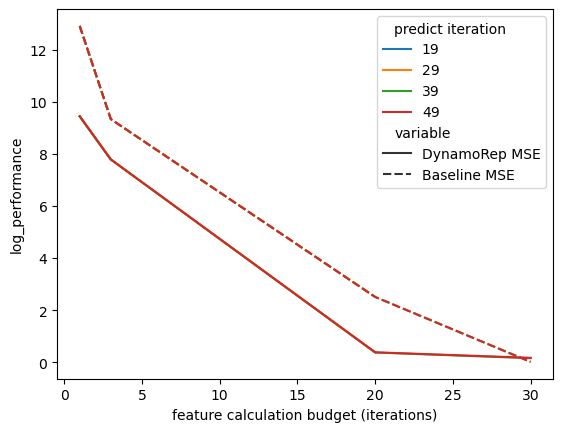

In [142]:
sns.lineplot(data=errors_for_dimension_df, palette="tab10",x='feature calculation budget (iterations)',y='log_performance',style='variable',hue='predict iteration',alpha=1)

<AxesSubplot: xlabel='feature calculation budget (iterations)', ylabel='log_performance'>

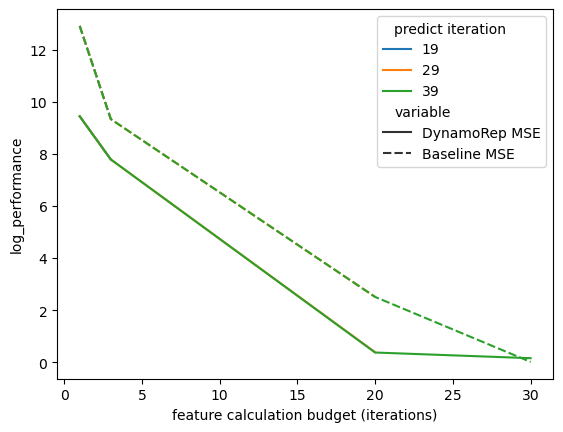

In [146]:
sns.lineplot(data=errors_for_dimension_df[errors_for_dimension_df["predict iteration"]<49], palette="tab10",x='feature calculation budget (iterations)',y='log_performance',style='variable',hue='predict iteration',alpha=1)

In [119]:
algorithm='DE'
dimension=20


errors_for_dimension=[]
for end_iteration in [0,2,4,9,19,29,39,49]:
    for predict_iteration in [2,4,9, 19,29,39,49]:
        if end_iteration<predict_iteration:
            errors_per_algorithm= get_errors_for_algorithm(dimension,algorithm,0,end_iteration=end_iteration, predict_iteration=predict_iteration,predict_log_precision=False,difference=False,seeds=seeds)
            print(errors_per_algorithm)
            errors_for_dimension+=[errors_per_algorithm]

errors_for_dimension_df=pd.DataFrame(errors_for_dimension, columns=['algorithm', 'feature calculation budget (iterations)', 'DynamoRep MSE', 'Baseline MSE','predict iteration'])
errors_for_dimension_df=errors_for_dimension_df.melt(id_vars=['algorithm','feature calculation budget (iterations)','predict iteration'], value_vars=['DynamoRep MSE', 'Baseline MSE'], value_name='performance')


('DE', 1, 23993832.878111277, 12742942.98148785, 2)
('DE', 1, 17774634.397899736, 18450799.34893203, 4)
('DE', 1, 9369713.375259314, 26186615.676173206, 9)
('DE', 1, 3439677.9524796996, 31753043.22530682, 19)
('DE', 1, 1375580.7849969785, 33679609.78182639, 29)
('DE', 1, 558265.3326935183, 34443182.737844266, 39)
('DE', 1, 231834.26255187218, 34745889.5899213, 49)
('DE', 3, 17730067.598904938, 7778364.913003978, 4)
('DE', 3, 9365854.693051355, 15392078.70706868, 9)
('DE', 3, 3437435.2667276817, 21015386.59070671, 19)
('DE', 3, 1375311.331957943, 22968767.683807235, 29)
('DE', 3, 558285.417155784, 23747230.474697825, 39)
('DE', 3, 231794.97074487986, 24056330.38108181, 49)
('DE', 5, 9363185.3032543, 9047935.04786163, 9)
('DE', 5, 3437334.5550652198, 14634510.56038993, 19)
('DE', 5, 1375382.7010454813, 16608964.970047867, 29)
('DE', 5, 558269.414318903, 17391325.519694462, 39)
('DE', 5, 231799.90812664715, 17704021.11919773, 49)
('DE', 10, 3436631.306158019, 6144283.233818944, 19)
('DE',

In [120]:
errors_for_dimension_df

,algorithm,feature calculation budget (iterations),predict iteration,variable,performance
0,DE,1,2,DynamoRep MSE,2.399383e+07
1,DE,1,4,DynamoRep MSE,1.777463e+07
2,DE,1,9,DynamoRep MSE,9.369713e+06
3,DE,1,19,DynamoRep MSE,3.439678e+06
4,DE,1,29,DynamoRep MSE,1.375581e+06
5,DE,1,39,DynamoRep MSE,5.582653e+05
6,DE,1,49,DynamoRep MSE,2.318343e+05
7,DE,3,4,DynamoRep MSE,1.773007e+07
8,DE,3,9,DynamoRep MSE,9.365855e+06
9,DE,3,19,DynamoRep MSE,3.437435e+06


In [54]:
errors_for_dimension_df['log_performance']=errors_for_dimension_df['performance'].apply(lambda p: math.log(p))

In [82]:
errors_for_dimension_df[errors_for_dimension_df['predict iteration']<20][errors_for_dimension_df['variable']=='DynamoRep MSE']

/tmp/ipykernel_89392/54515923.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  errors_for_dimension_df[errors_for_dimension_df['predict iteration']<20][errors_for_dimension_df['variable']=='DynamoRep MSE']


,algorithm,feature calculation budget (iterations),predict iteration,variable,performance,log_performance
0,DE,1,2,DynamoRep MSE,3.279924e+13,31.121426
1,DE,1,4,DynamoRep MSE,1.333025e+13,30.221057
2,DE,1,9,DynamoRep MSE,2.261451e+12,28.447028
3,DE,1,19,DynamoRep MSE,1.231503e+11,25.536671
7,DE,3,4,DynamoRep MSE,1.323274e+13,30.213715
8,DE,3,9,DynamoRep MSE,2.254096e+12,28.443770
9,DE,3,19,DynamoRep MSE,1.230743e+11,25.536054
13,DE,5,9,DynamoRep MSE,2.252132e+12,28.442898
14,DE,5,19,DynamoRep MSE,1.230482e+11,25.535842
18,DE,10,19,DynamoRep MSE,1.229836e+11,25.535317


/tmp/ipykernel_89392/987423116.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(data=errors_for_dimension_df[errors_for_dimension_df['predict iteration']<20][errors_for_dimension_df['variable']=='DynamoRep MSE'], palette="tab10",x='feature calculation budget (iterations)',y='performance',style='variable',hue='predict iteration',alpha=0.7)


<AxesSubplot: xlabel='feature calculation budget (iterations)', ylabel='performance'>

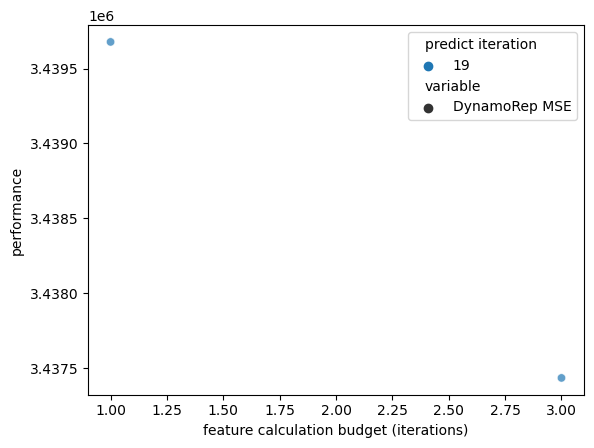

In [116]:
sns.scatterplot(data=errors_for_dimension_df[errors_for_dimension_df['predict iteration']<20][errors_for_dimension_df['variable']=='DynamoRep MSE'], palette="tab10",x='feature calculation budget (iterations)',y='performance',style='variable',hue='predict iteration',alpha=0.7)

<AxesSubplot: xlabel='feature calculation budget (iterations)', ylabel='performance'>

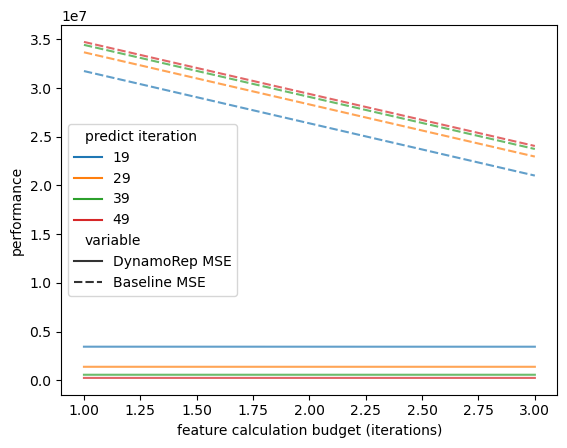

In [118]:
sns.lineplot(data=errors_for_dimension_df[errors_for_dimension_df['feature calculation budget (iterations)']<4], palette="tab10",x='feature calculation budget (iterations)',y='performance',style='variable',hue='predict iteration',alpha=0.7)

<AxesSubplot: xlabel='feature calculation budget (iterations)', ylabel='performance'>

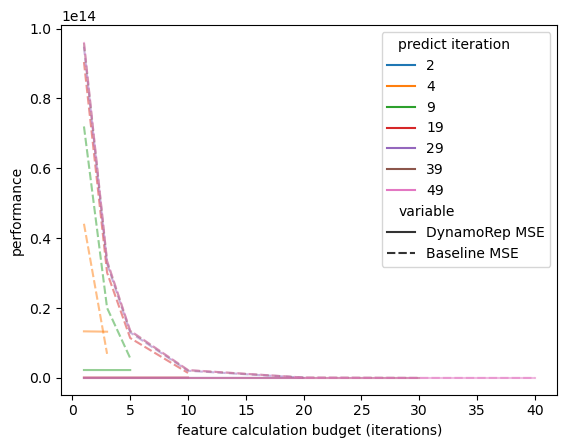

In [61]:
sns.lineplot(data=errors_for_dimension_df, palette="tab10",x='feature calculation budget (iterations)',y='performance',style='variable',hue='predict iteration',alpha=0.5)

<AxesSubplot: xlabel='feature calculation budget (iterations)', ylabel='log_performance'>

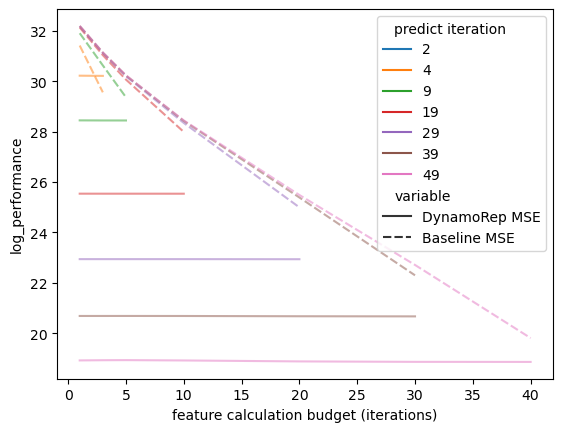

In [63]:
sns.lineplot(data=errors_for_dimension_df, palette="tab10",x='feature calculation budget (iterations)',y='log_performance',style='variable',hue='predict iteration',alpha=0.5)

KeyboardInterrupt: 

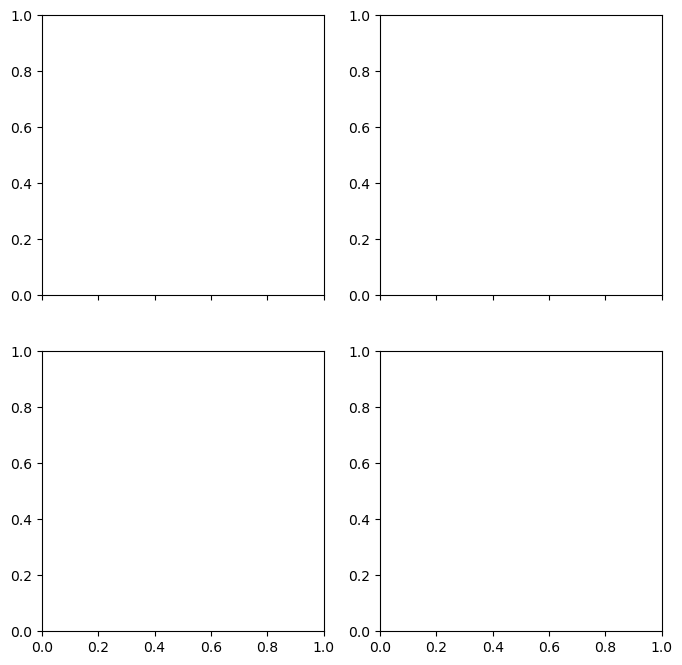

In [17]:
dimension=5
all_algorithms=['DE','CMAES','ES','PSO']
fig, axes = plt.subplots(int(len(all_algorithms)/2),2, figsize=(8,8), sharex=True)

for algorithm_index, algorithm in enumerate(all_algorithms):
    for predict_log_precision in [False]:
        
        for difference in [False]:
            errors_for_dimension=[]
            for end_iteration in [0,2,4,9,19,29,39,49]:
                for predict_iteration in [49]:
                    if end_iteration<predict_iteration:
                        errors_per_algorithm= get_errors_for_algorithm(dimension,algorithm,0,end_iteration=end_iteration, predict_iteration=predict_iteration,predict_log_precision=predict_log_precision,difference=difference,seeds=seeds)
                        errors_for_dimension+=[errors_per_algorithm]
                
            errors_for_dimension_df=pd.DataFrame(errors_for_dimension, columns=['algorithm', 'feature calculation budget (iterations)', 'DynamoRep MAE',  'Baseline MAE','DynamoRep RMSE', 'Baseline RMSE'])
            errors_for_dimension_df=errors_for_dimension_df.melt(id_vars=['algorithm','feature calculation budget (iterations)'], value_vars=['DynamoRep MAE',  'Baseline MAE','DynamoRep RMSE', 'Baseline RMSE'], value_name='performance')
            
            
    ax=axes[int(algorithm_index/2), algorithm_index%2] if type(axes) is np.ndarray else axes
    ax.set_title(f'Algorithm: {algorithm}')
    g = sns.barplot(data=errors_for_dimension_df,x='feature calculation budget (iterations)', y="performance", hue="variable", palette=color_palette,ax=ax)
    if algorithm_index != 0:
        ax.get_legend().remove()
plt.tight_layout()
plt.show()
        

In [133]:
dimension=5

for algorithm in ['DE']:
    for predict_log_precision in [False]:
        for difference in [False]:
            for end_iteration in [2,9,19]:
                 for predict_iteration in [29,49]:
                    if end_iteration<predict_iteration:
                        print(algorithm,'log:',predict_log_precision,'diff:',difference,'it:',end_iteration)

                        all_predictions = get_predictions_df(dimension,algorithm,0,end_iteration,predict_iteration=predict_iteration,predict_log_precision=predict_log_precision,difference=difference,seeds=seeds)
                        if all_predictions.shape[0]==0:
                            continue



                        for problem_id in range(1,25):
                            print('PID', problem_id, 'END', end_iteration, 'PREDICT', predict_iteration)
                            problem_predictions=all_predictions.query('problem_id==@problem_id and instance_id==1')
                            print(mean_absolute_error(problem_predictions['y'], problem_predictions['preds']))
                            print(mean_squared_error(problem_predictions['y'], problem_predictions['preds'], squared=False))

DE log: False diff: False it: 2
PID 1 END 2 PREDICT 29
4.4157940117858985
5.155080232572199
PID 2 END 2 PREDICT 29
9058.908943114488
12023.16187048424
PID 3 END 2 PREDICT 29
18.178689636820614
21.09576234155867
PID 4 END 2 PREDICT 29
18.326206067450677
19.940022052580414
PID 5 END 2 PREDICT 29
28.5926545373504
50.356920633723824
PID 6 END 2 PREDICT 29
173.62555537882616
193.70795170168415
PID 7 END 2 PREDICT 29
31.91639550674006
35.7482168453047
PID 8 END 2 PREDICT 29
176.64779173574124
191.8380727844822
PID 9 END 2 PREDICT 29
360.7768828712314
389.9021080999939
PID 10 END 2 PREDICT 29
5385.459609142637
6137.396731685457
PID 11 END 2 PREDICT 29
6566.9694458798795
6870.174794420136
PID 12 END 2 PREDICT 29
782705.4108569126
1070726.484973834
PID 13 END 2 PREDICT 29
202.0197073685252
217.48222455796744
PID 14 END 2 PREDICT 29
16.8455015452329
17.744306008575606
PID 15 END 2 PREDICT 29
104.05368283550722
141.1701011027512
PID 16 END 2 PREDICT 29
6.435393580572297
8.6209074986108
PID 17 END

In [72]:
a=pd.read_csv('performance_prediction_results_different_iterations/dim_10_CMAES_it_0-0_predict_it_19_instance_count_99_seed_400_log_False_fold_5_test_preds.csv', compression='zip')

In [73]:
a

,algorithm_name,problem_id,instance_id,seed,y,preds
0,CMAES,15,1,400,55.745302,170.465904
1,CMAES,15,2,400,85.868002,33.442661
2,CMAES,15,3,400,100.116935,59.749129
3,CMAES,15,4,400,92.321724,64.707750
4,CMAES,15,5,400,53.747045,44.769684
...,...,...,...,...,...,...
193,CMAES,16,95,400,11.026666,4.624311
194,CMAES,16,96,400,7.568719,3.121342
195,CMAES,16,97,400,9.451530,3.703270
196,CMAES,16,98,400,11.853972,3.915231


In [110]:
b=pd.read_csv('performance_prediction_results_different_iterations/dim_10_CMAES_it_0-2_predict_it_29_instance_count_99_seed_400_log_False_fold_6_test_preds.csv', compression='zip')

In [111]:
b

,algorithm_name,problem_id,instance_id,seed,y,preds
0,CMAES,17,1,400,3.309299,6.121809
1,CMAES,17,2,400,2.212731,30.165377
2,CMAES,17,3,400,3.359847,8.113285
3,CMAES,17,4,400,2.181457,25.910511
4,CMAES,17,5,400,4.056403,42.850068
...,...,...,...,...,...,...
193,CMAES,18,95,400,22.069691,52.327059
194,CMAES,18,96,400,5.772130,11.352444
195,CMAES,18,97,400,14.806894,15.269404
196,CMAES,18,98,400,18.066802,4.749177


In [112]:
c=pd.read_csv('performance_prediction_results_different_iterations/dim_10_CMAES_it_0-9_predict_it_29_instance_count_99_seed_400_log_False_fold_6_test_preds.csv', compression='zip')

In [113]:
c

,algorithm_name,problem_id,instance_id,seed,y,preds
0,CMAES,17,1,400,0.456571,10.099408
1,CMAES,17,2,400,0.291787,36.541744
2,CMAES,17,3,400,0.560095,9.409705
3,CMAES,17,4,400,0.790696,21.857489
4,CMAES,17,5,400,0.630246,23.745443
...,...,...,...,...,...,...
193,CMAES,18,95,400,8.342653,18.478912
194,CMAES,18,96,400,1.312471,1.607609
195,CMAES,18,97,400,2.041477,15.364351
196,CMAES,18,98,400,5.298035,9.923168


In [121]:
c=pd.read_csv('performance_prediction_results_different_iterations/dim_10_CMAES_it_0-9_predict_it_29_instance_count_99_seed_400_log_False_fold_6_feature_importance.csv', compression='zip')

In [125]:
c.T.sort_values(0).tail(20)

,0
min_it_2_dim_1,0.003783
std_it_4_dim_8,0.004600
max_it_9_dim_1,0.005169
std_it_5_dim_6,0.005521
min_it_1_dim_10,0.007517
std_it_4_dim_2,0.007764
min_it_8_dim_2,0.008639
std_it_6_dim_10,0.009275
max_it_6_dim_7,0.009320
std_it_2_dim_4,0.010216
